<a href="https://colab.research.google.com/github/jwyangyin/TFM/blob/main/Notebook_1_%E2%80%94_Filtrado_Colaborativo_Item_to_Item_(All_Beauty).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFM - Sistema de recomendación por Filtrado Colaborativo Item-to-Item  
En este cuaderno se implementa un sistema de recomendación item-to-item usando el dataset **Amazon Reviews 2023 - All_Beauty**.  
Se trabaja a nivel de `parent_asin` (producto padre).

<h2>Índice del cuaderno</h2>

<ol>
  <li><b>Preparación de datos</b>
    <ol>
      <li>Selección y limpieza de columnas</li>
      <li>Estadísticas básicas (EDA)</li>
      <li>Distribuciones de usuarios, productos y ratings</li>
      <li>Evolución temporal de las interacciones</li>
      <li>Análisis avanzado del dataset
        <ol>
          <li>Distribución de actividad de usuarios</li>
          <li>Popularidad de productos (long tail)</li>
          <li>Ratings promedio por usuario y por producto</li>
          <li>Mapa de dispersión de la matriz usuario–item</li>
        </ol>
      </li>
    </ol>
  </li>

  <li><b>Construcción de la matriz usuario–item</b>
    <ol>
      <li>Filtrado de usuarios y productos poco activos</li>
      <li>Mapeo de IDs a índices</li>
      <li>Matriz dispersa usuario–item</li>
    </ol>
  </li>

  <li><b>Partición temporal train/test</b></li>

  <li><b>Similitud item–item</b>
    <ol>
      <li>Función genérica de similitud (coseno, euclidea)</li>
      <li>Cálculo de la matriz item–item (métrica base: coseno)</li>
    </ol>
  </li>

  <li><b>Sistema de recomendación item–item</b>
    <ol>
      <li>Función de recomendación para un usuario</li>
      <li>Ejemplo de recomendaciones</li>
    </ol>
  </li>

  <li><b>Evaluación del modelo</b>
    <ol>
      <li>Métricas Precision@K y Recall@K</li>
      <li>Comparación de distintas métricas de similitud</li>
    </ol>
  </li>

  <li><b>Cobertura del sistema</b>
    <ol>
      <li>Definición y cálculo de Cobertura@K</li>
    </ol>
  </li>

  <li><b>Experimento con subconjunto del 20 % de productos</b>
    <ol>
      <li>Construcción del subset</li>
      <li>Entrenamiento del segundo modelo item–item</li>
      <li>Evaluación y cobertura del modelo de subset</li>
      <li>Comparación full vs subset</li>
    </ol>
  </li>

  <li><b>Resumen técnico (enlace para la memoria)</b></li>
</ol>


# 1. Preparación de datos

In [1]:
# Importamos las librerías necesarias:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
import time
import random
import json

In [2]:
# Montamos nuestro Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Definimos las rutas donde están los archivos JSONL subidos a Google Colab:
path_reviews = '/content/drive/My Drive/Colab Notebooks/All_Beauty.jsonl'
path_meta   = '/content/drive/My Drive/Colab Notebooks/meta_All_Beauty.jsonl'

# Cargamos el archivo de reseñas:
reviews = []
with open(path_reviews, "r") as f:
    for line in f:
        reviews.append(json.loads(line.strip()))

df_reviews = pd.DataFrame(reviews)
df_reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [4]:
# Cargamos el archivo de meta:
meta = []
with open(path_meta, "r") as f:
    for line in f:
        meta.append(json.loads(line.strip()))
df_meta = pd.DataFrame(meta)
df_meta.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,None
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,None
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,None
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Cherioll,[],"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...",B088FKY3VD,None
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"[Material: 304 Stainless Steel; Brass tip, Len...",[The Precision Plunger Bars are designed to wo...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Precision,[],{'UPC': '644287689178'},B07NGFDN6G,None


## 1.1. Selección y limpieza de columnas

En esta sección preparamos el subconjunto de datos necesario para el sistema
item-to-item a nivel de `parent_asin`.

In [5]:
# Nos quedamos solo con las columnas necesarias para el filtrado colaborativo item-to-item:
cols_reviews = ["user_id", "parent_asin", "rating", "timestamp"]
df = df_reviews[cols_reviews].dropna(subset=["user_id", "parent_asin", "rating"])

# Aseguramos el tipo de dato para cada variable:
df["rating"] = df["rating"].astype(float)
df["user_id"] = df["user_id"].astype(str)
df["parent_asin"] = df["parent_asin"].astype(str)

df.head()

,user_id,parent_asin,rating,timestamp
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,5.0,1588687728923
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,4.0,1588615855070
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,5.0,1589665266052
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,1.0,1643393630220
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,5.0,1609322563534


## 1.2 Estadísticas básicas (EDA)

Se muestran estadísticas básicas necesarias para entender el problema:  
- número de usuarios únicos  
- número de productos (`parent_asin`)  
- número total de interacciones (reviews)  
- densidad de la matriz usuario–producto


In [6]:
n_users = df["user_id"].nunique()
n_items = df["parent_asin"].nunique()
n_interactions = len(df)

density = n_interactions / (n_users * n_items)

print(f"Número de usuarios: {n_users}")
print(f"Número de productos (parent_asin): {n_items}")
print(f"Número de interacciones (reviews): {n_interactions}")
print(f"Densidad de la matriz usuario–producto: {density:.8f}")

Número de usuarios: 631986
Número de productos (parent_asin): 112565
Número de interacciones (reviews): 701528
Densidad de la matriz usuario–producto: 0.00000986


## 1.3 Distribuciones de usuarios, productos y ratings

Se visualizan:
- la distribución de ratings  
- la distribución del número de reviews por usuario  
- la distribución del número de reviews por producto  

Las escalas logarítmicas permiten observar la típica distribución de “larga cola”.

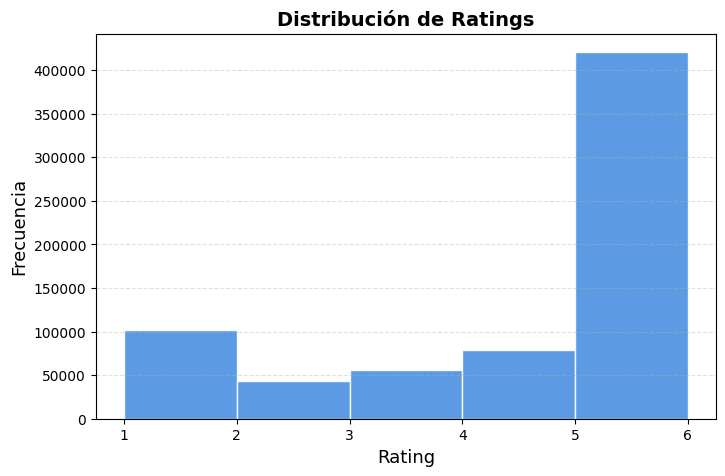

In [50]:
# Distribución de ratings:
plt.figure(figsize=(8,5))
plt.hist(df["rating"], bins=[1,2,3,4,5,6], color="#4A90E2", edgecolor="white", alpha=0.9)

plt.title("Distribución de Ratings", fontsize=14, weight="bold")
plt.xlabel("Rating", fontsize=13)
plt.ylabel("Frecuencia", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

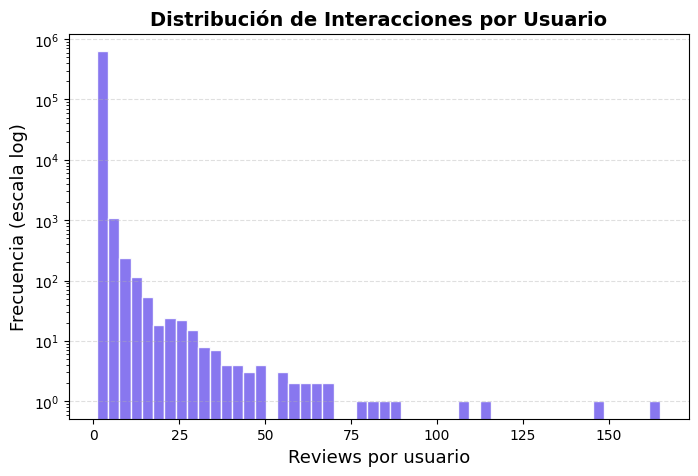

In [49]:
# Nº de reviews por usuario:
plt.figure(figsize=(8,5))
plt.hist(user_counts, bins=50, color="#7B68EE", edgecolor="white", alpha=0.9)
plt.yscale("log")

plt.title("Distribución de Interacciones por Usuario", fontsize=14, weight="bold")
plt.xlabel("Reviews por usuario", fontsize=13)
plt.ylabel("Frecuencia (escala log)", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()

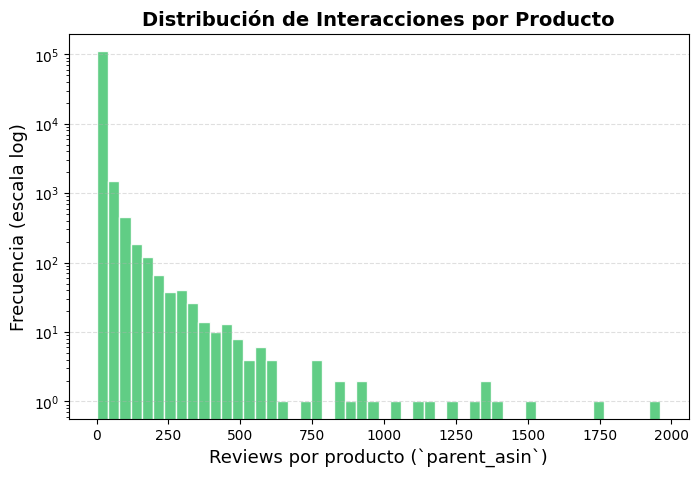

In [48]:
# Nº de reviews por producto:
plt.figure(figsize=(8,5))
plt.hist(item_counts, bins=50, color="#50C878", edgecolor="white", alpha=0.9)
plt.yscale("log")

plt.title("Distribución de Interacciones por Producto", fontsize=14, weight="bold")
plt.xlabel("Reviews por producto (`parent_asin`)", fontsize=13)
plt.ylabel("Frecuencia (escala log)", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()


In [35]:
summary_df = pd.DataFrame({
    "Métrica": ["Usuarios únicos", "Productos", "Interacciones", "Densidad"],
    "Valor": [n_users, n_items, n_interactions, round(density, 8)]
})

summary_df


,Métrica,Valor
0,Usuarios únicos,631986.00000
1,Productos,112565.00000
2,Interacciones,701528.00000
3,Densidad,0.00001


## 1.4 Evolución temporal de las interacciones

Se analiza la evolución mensual del número de reviews para estudiar cambios en el uso del sistema a lo largo del tiempo.

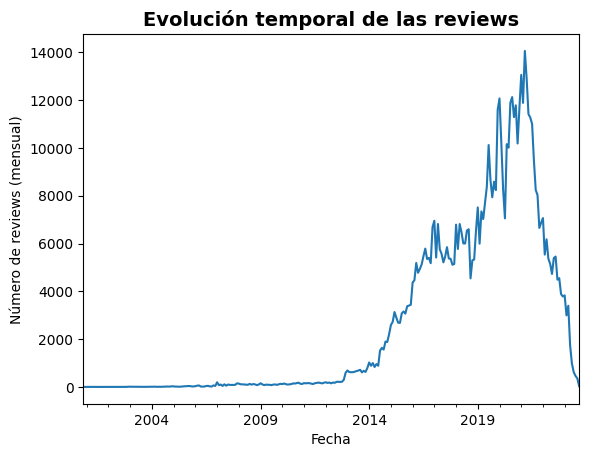

In [47]:
df["fecha"] = pd.to_datetime(df["timestamp"], unit="ms")

interacciones_por_mes = df.set_index("fecha").resample("ME")["user_id"].count()

plt.figure()
interacciones_por_mes.plot()
plt.xlabel("Fecha")
plt.ylabel("Número de reviews (mensual)")
plt.title("Evolución temporal de las reviews",fontsize=14,weight="bold")
plt.show()

<h2>1.5 Análisis avanzado del dataset</h2>

<h3>1.5.1 Distribución de actividad de usuarios</h3>

<p>
En primer lugar se analiza cuántos productos ha valorado cada usuario. Esto permite
identificar usuarios de baja, media y alta actividad, lo cual es relevante para el
problema de <i>cold-start</i> y para justificar el filtrado posterior.
</p>

<ul>
  <li><b>Usuarios de baja actividad</b>: menos de 3 reviews.</li>
  <li><b>Usuarios de actividad media</b>: entre 3 y 10 reviews.</li>
  <li><b>Usuarios muy activos</b>: más de 10 reviews.</li>
</ul>

<p>
La mayoría de usuarios se concentran en los niveles de baja actividad, lo que
refuerza la idea de que el dataset es altamente disperso y que el sistema de
recomendación tendrá poca información para muchos usuarios.
</p>

In [42]:
# 1.5.1 Distribución de actividad de usuarios

# Nº de reseñas por usuario
user_counts = df.groupby("user_id")["parent_asin"].count()

# Clasificación por tramos
bins = [0, 3, 10, user_counts.max() + 1]  # +1 para incluir el máximo
labels = ["Baja actividad (<3)", "Media actividad (3–10)", "Alta actividad (>10)"]

user_activity = pd.cut(user_counts, bins=bins, labels=labels, right=False)

# Tabla resumen
user_activity.value_counts().reindex(labels)

,count
parent_asin,
Baja actividad (<3),622827
Media actividad (3–10),8829
Alta actividad (>10),330


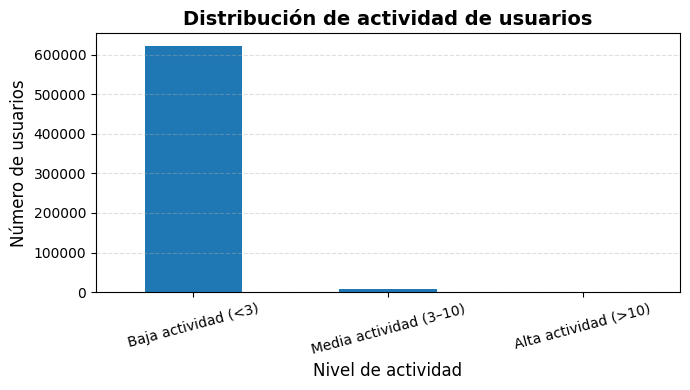

In [44]:
# Gráfico de barras de actividad de usuarios
plt.figure(figsize=(7,4))
user_activity.value_counts().reindex(labels).plot(kind="bar")

plt.title("Distribución de actividad de usuarios", fontsize=14,weight="bold")
plt.xlabel("Nivel de actividad", fontsize=12)
plt.ylabel("Número de usuarios", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

<h2>1.5.2 Popularidad de productos (long tail)</h2>

<p>
En esta sección se analiza la <b>popularidad de los productos</b> midiendo cuántas reseñas recibe cada
<code>parent_asin</code>. En catálogos reales suele aparecer el patrón de <b>larga cola (long tail)</b>:
</p>

<ul>
  <li>Un pequeño grupo de productos concentra muchas reseñas (productos muy populares).</li>
  <li>La mayoría de productos tiene pocas reseñas (productos poco populares).</li>
</ul>

<p>
Para visualizarlo se ordenan los productos por número de reseñas y se representa en escala <b>log-log</b>,
lo que permite observar la larga cola de forma más clara.
</p>

Productos únicos: 112,565
Interacciones totales: 701,528
Top 1% productos concentran: 27.86% de las reseñas
Top 5% productos concentran: 50.93% de las reseñas


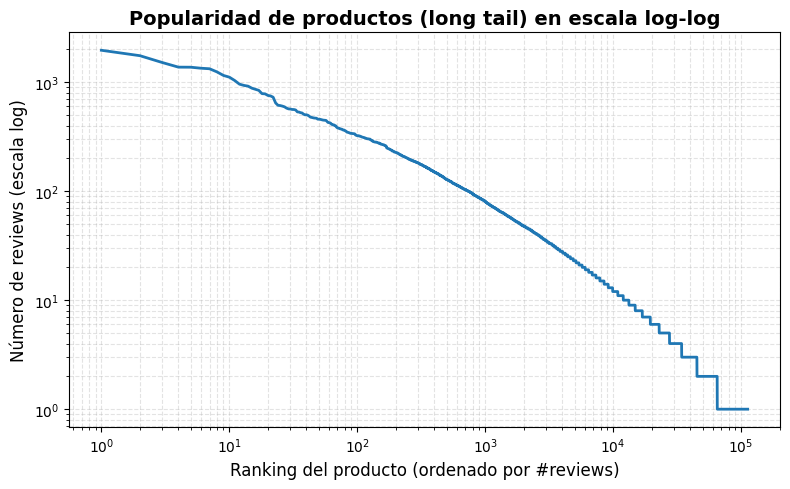

In [46]:
# 1.5.2 Popularidad de productos (long tail)

# Conteo de reviews por producto (parent_asin)
item_counts = df.groupby("parent_asin")["user_id"].count().sort_values(ascending=False)

# --- Resumen numérico útil (para el informe) ---
top_1pct = int(len(item_counts) * 0.01)
top_5pct = int(len(item_counts) * 0.05)

share_top1 = item_counts.iloc[:top_1pct].sum() / item_counts.sum() if top_1pct > 0 else 0
share_top5 = item_counts.iloc[:top_5pct].sum() / item_counts.sum() if top_5pct > 0 else 0

print(f"Productos únicos: {len(item_counts):,}")
print(f"Interacciones totales: {item_counts.sum():,}")
print(f"Top 1% productos concentran: {share_top1:.2%} de las reseñas")
print(f"Top 5% productos concentran: {share_top5:.2%} de las reseñas")

# --- Gráfico long tail (log-log) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(item_counts) + 1), item_counts.values, linewidth=2)

plt.xscale("log")
plt.yscale("log")

plt.title("Popularidad de productos (long tail) en escala log-log", fontsize=14,weight="bold")
plt.xlabel("Ranking del producto (ordenado por #reviews)", fontsize=12)
plt.ylabel("Número de reviews (escala log)", fontsize=12)

plt.grid(True, which="both", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

<h3>1.5.3 Ratings promedio por usuario y por producto</h3>

<p>
Para entender mejor el comportamiento de usuarios y productos, se analiza la
distribución del <b>rating promedio por usuario</b> y del <b>rating promedio por
producto</b>.
</p>

<ul>
  <li>Los usuarios con medias muy altas o muy bajas indican <i>sesgo de valoración</i>.</li>
  <li>Los productos con medias extremas (por ejemplo, cercanas a 5.0) pueden estar
      influidos por pocos usuarios o por opiniones muy polarizadas.</li>
</ul>

<p>
Este análisis es útil para discutir posibles normalizaciones de ratings y para
interpretar los resultados del sistema de recomendación.
</p>


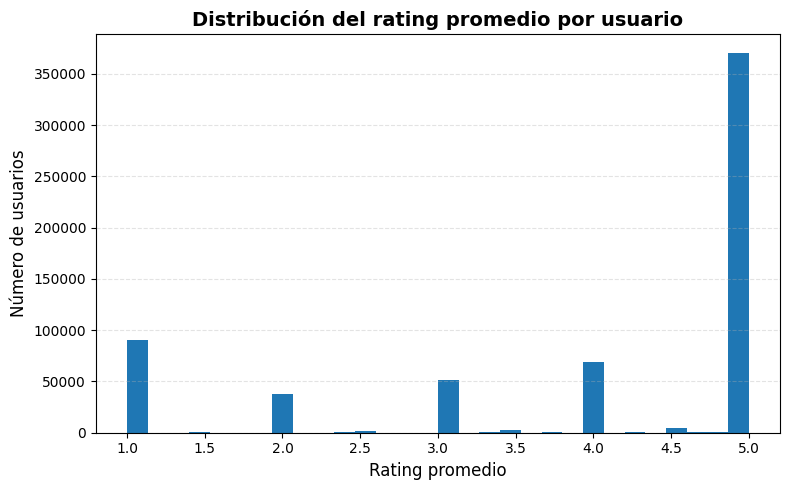

,rating
count,631986.000000
mean,3.948681
std,1.487903
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [51]:
# 1.5.3 Rating promedio por usuario

avg_rating_user = df.groupby("user_id")["rating"].mean()

plt.figure(figsize=(8,5))
plt.hist(avg_rating_user, bins=30)

plt.title("Distribución del rating promedio por usuario", fontsize=14, weight="bold")
plt.xlabel("Rating promedio", fontsize=12)
plt.ylabel("Número de usuarios", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

# Estadísticas resumen
avg_rating_user.describe()

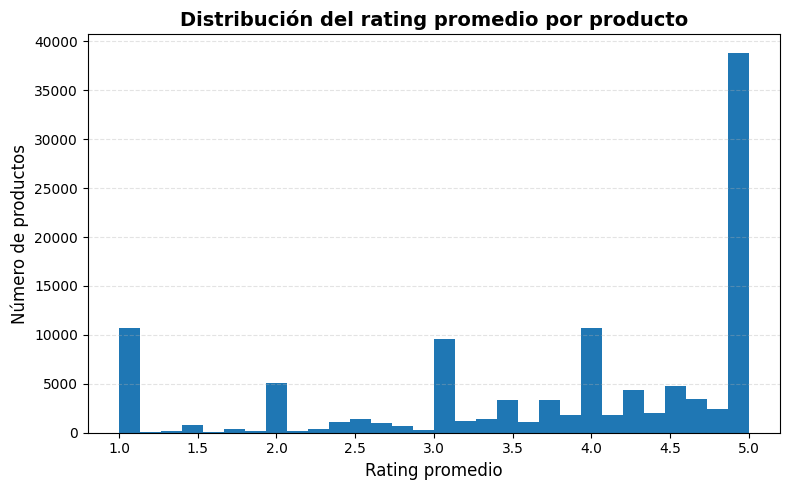

,rating
count,112565.000000
mean,3.815085
std,1.298187
min,1.000000
25%,3.000000
50%,4.166667
75%,5.000000
max,5.000000


In [52]:
# 1.5.3 Rating promedio por producto

avg_rating_item = df.groupby("parent_asin")["rating"].mean()

plt.figure(figsize=(8,5))
plt.hist(avg_rating_item, bins=30)

plt.title("Distribución del rating promedio por producto", fontsize=14, weight="bold")
plt.xlabel("Rating promedio", fontsize=12)
plt.ylabel("Número de productos", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

# Estadísticas resumen
avg_rating_item.describe()

<h2>1.5.4 Mapa de dispersión de la matriz usuario–item</h2>

<p>
En este apartado se visualiza la estructura de la matriz usuario–item mediante un
<b>mapa de dispersión</b> (<i>spy plot</i>). Cada punto del gráfico representa una
interacción observada entre un usuario y un producto.
</p>

<p>
Este tipo de visualización permite apreciar de forma intuitiva el nivel de
<b>dispersión (sparsity)</b> del dataset. En sistemas de recomendación reales,
la mayoría de combinaciones usuario–producto no presentan interacción.
</p>

<p>
Dado el gran tamaño de la matriz original, se utiliza un <b>subconjunto aleatorio</b>
de usuarios y productos para facilitar la visualización, manteniendo la estructura
general de dispersión.
</p>


In [53]:
# 1.5.4 Mapa de dispersión (spy plot) de la matriz usuario–item
# Se utiliza un subconjunto para visualización
from scipy.sparse import csr_matrix
import numpy as np

# Semilla para reproducibilidad
rng = np.random.default_rng(42)

# Tamaño del subconjunto (ajustable si quieres)
max_users = 1500
max_items = 1500

# Selección aleatoria de usuarios y productos
sample_users = rng.choice(df["user_id"].unique(),
                          size=min(max_users, df["user_id"].nunique()),
                          replace=False)

sample_items = rng.choice(df["parent_asin"].unique(),
                          size=min(max_items, df["parent_asin"].nunique()),
                          replace=False)

df_sample = df[
    df["user_id"].isin(sample_users) &
    df["parent_asin"].isin(sample_items)
].copy()

df_sample.shape

(12, 5)

In [54]:
# Mapear IDs a índices consecutivos
user_to_idx = {u: i for i, u in enumerate(df_sample["user_id"].unique())}
item_to_idx = {i: j for j, i in enumerate(df_sample["parent_asin"].unique())}

df_sample["user_idx"] = df_sample["user_id"].map(user_to_idx)
df_sample["item_idx"] = df_sample["parent_asin"].map(item_to_idx)

# Dimensiones
n_users = len(user_to_idx)
n_items = len(item_to_idx)

# Matriz dispersa
R_sample = csr_matrix(
    (np.ones(len(df_sample)),  # usamos 1 para indicar interacción
     (df_sample["user_idx"], df_sample["item_idx"])),
    shape=(n_users, n_items)
)

R_sample.shape

(12, 12)

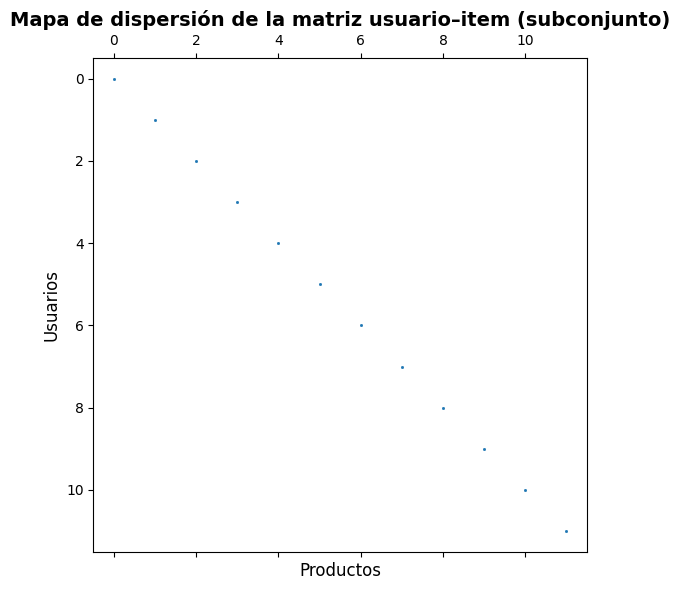

In [55]:
# Spy plot mejorado

plt.figure(figsize=(6,6))
plt.spy(R_sample, markersize=1)

plt.title("Mapa de dispersión de la matriz usuario–item (subconjunto)",
          fontsize=14, weight="bold")
plt.xlabel("Productos", fontsize=12)
plt.ylabel("Usuarios", fontsize=12)

plt.tight_layout()
plt.show()

## 2.1 Filtrado de usuarios y productos poco activos

Para mejorar la calidad de las recomendaciones y la eficiencia del modelo,
se eliminan usuarios y productos con muy pocas interacciones.

In [9]:
# Filtrado de usuarios y productos pocos activos:
MIN_RATINGS_USER = 3
MIN_RATINGS_ITEM = 3

filtered = df.copy()

user_counts = filtered.groupby("user_id")["parent_asin"].count()
item_counts = filtered.groupby("parent_asin")["user_id"].count()

filtered = filtered[filtered["user_id"].isin(user_counts[user_counts >= MIN_RATINGS_USER].index)]
filtered = filtered[filtered["parent_asin"].isin(item_counts[item_counts >= MIN_RATINGS_ITEM].index)]

print("Después del filtrado:")
print("Usuarios:", filtered["user_id"].nunique())
print("Items:", filtered["parent_asin"].nunique())
print("Interacciones:", len(filtered))

Después del filtrado:
Usuarios: 9016
Items: 13671
Interacciones: 33305


## 2.2 Mapeo de IDs y construcción de la matriz usuario–item

Se asigna un índice entero a cada usuario y a cada producto para construir
una matriz dispersa `R` de tamaño `n_usuarios x n_items`.

In [10]:
# Matriz usuario-item:
# Mapas de ids a índices:
user_to_idx = {u: i for i, u in enumerate(filtered["user_id"].unique())}
item_to_idx = {i: j for j, i in enumerate(filtered["parent_asin"].unique())}
idx_to_item = {j: i for i, j in item_to_idx.items()}

filtered["user_idx"] = filtered["user_id"].map(user_to_idx)
filtered["item_idx"] = filtered["parent_asin"].map(item_to_idx)

n_users_f = len(user_to_idx)
n_items_f = len(item_to_idx)

print("Usuarios (filtrados):", n_users_f)
print("Items (filtrados):", n_items_f)

# Matriz usuario–item (ratings):
R = csr_matrix(
    (filtered["rating"], (filtered["user_idx"], filtered["item_idx"])),
    shape=(n_users_f, n_items_f)
)
R

Usuarios (filtrados): 9016
Items (filtrados): 13671


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 30674 stored elements and shape (9016, 13671)>

## 3. Partición temporal train/test

Se utiliza una partición temporal tipo *leave-one-out* por usuario:  
la última interacción de cada usuario se reserva para test,
las anteriores se utilizan para entrenar el modelo.

In [11]:
# Partición temporal:
filtered = filtered.sort_values(by=["user_idx", "timestamp"])

test_indices = filtered.groupby("user_idx").tail(1).index
df_test = filtered.loc[test_indices]
df_train = filtered.drop(test_indices)

print("Interacciones train:", len(df_train))
print("Interacciones test:", len(df_test))

R_train = csr_matrix(
    (df_train["rating"], (df_train["user_idx"], df_train["item_idx"])),
    shape=(n_users_f, n_items_f)
)

Interacciones train: 24289
Interacciones test: 9016


## 4.1 Función genérica de similitud item–item

Se calcula una matriz item–item usando distintas métricas de similitud
(coseno, euclídea y correlación).  
Esto permite comparar el rendimiento del modelo según la medida utilizada.

In [12]:
# Función de similitud:
def compute_item_similarity(R_train, metric="cosine"):
    """
    Calcula la matriz item-item de similitud (o distancia convertida en similitud).
    metric: 'cosine', 'euclidean', 'correlation'
    """
    t0 = time.perf_counter()

    if metric == "cosine":
        sim = cosine_similarity(R_train.T)  # items x items
    else:
        dist = pairwise_distances(R_train.T, metric=metric)
        max_dist = np.max(dist)
        if max_dist == 0:
            sim = 1 - dist
        else:
            sim = 1 - dist / max_dist

    t1 = time.perf_counter()
    print(f"Matriz de similitud '{metric}' calculada en {t1 - t0:.2f} segundos")
    return sim

## 4.2 Matriz item–item (métrica base: coseno)


In [13]:
SIMILARITY_METRIC = "cosine"
S_item_cosine = compute_item_similarity(R_train, metric=SIMILARITY_METRIC)
S_item_cosine.shape

Matriz de similitud 'cosine' calculada en 0.35 segundos


(13671, 13671)

## 5.1 Función de recomendación item-to-item

A partir de la matriz de similitud, se generan recomendaciones para cada usuario
ponderando los ítems similares a los que ya ha valorado.

In [14]:
# Función de recomendación:
def recommend_items_item2item(user_idx, R_train, S_item, top_k=10, top_n_sim=50):
    """
    Genera recomendaciones para un usuario con filtrado colaborativo item-to-item.
    - user_idx: índice numérico del usuario
    - top_n_sim: nº de ítems similares considerados por cada ítem visto
    """
    user_ratings = R_train[user_idx].toarray().ravel()
    interacted_items = np.where(user_ratings > 0)[0]

    if len(interacted_items) == 0:
        return []

    scores = np.zeros(S_item.shape[0])

    for item in interacted_items:
        sim_items = S_item[item]
        top_sim_indices = np.argpartition(-sim_items, top_n_sim)[:top_n_sim]
        scores[top_sim_indices] += sim_items[top_sim_indices] * user_ratings[item]

    # Excluir ítems ya vistos
    scores[interacted_items] = -np.inf

    top_items = np.argpartition(-scores, top_k)[:top_k]
    top_scores = scores[top_items]

    order = np.argsort(-top_scores)
    top_items = top_items[order]
    top_scores = top_scores[order]

    return list(zip(top_items, top_scores))

In [15]:
# Ejemplo de recomendaciones:
ejemplo_user_idx = df_train["user_idx"].sample(1, random_state=42).iloc[0]
print("Usuario índice:", ejemplo_user_idx)

recs = recommend_items_item2item(ejemplo_user_idx, R_train, S_item_cosine, top_k=10)

resultado = pd.DataFrame({
    "item_idx": [i for i, s in recs],
    "parent_asin": [idx_to_item[i] for i, s in recs],
    "score": [float(s) for i, s in recs]
})
resultado

Usuario índice: 185


,item_idx,parent_asin,score
0,9617,B08SMQ79L3,7.055736
1,9618,B082WWY5WW,7.055736
2,9613,B08ZRTMTJH,7.055736
3,9616,B0928JPNSY,7.055736
4,9615,B093PLB98K,6.551086
5,6721,B083BGCKLF,6.393056
6,523,B06XBS6MHQ,6.047224
7,477,B08LDGRY6Q,6.047224
8,507,B089JYBGVC,6.047224
9,9612,B0968553LW,5.746780


## 6.1 Métricas de evaluación: Precision@K y Recall@K

Para evaluar la calidad del sistema item-to-item se utiliza un esquema *leave-one-out*:
- Para cada usuario se deja su última interacción como test.
- Se evalúa si el ítem reservado aparece en el Top-K recomendado.

In [16]:
# Función de evaluación: Precision@K y Recall@K
def precision_recall_at_k(R_train, df_test, S_item, k=10):
    hits = 0
    total_relevant = len(df_test)     # 1 ítem relevante por usuario
    total_recommended = 0

    for _, row in df_test.iterrows():
        u_idx = int(row["user_idx"])
        true_item = row["item_idx"]

        recs = recommend_items_item2item(u_idx, R_train, S_item, top_k=k)
        recommended_items = [i for i, _ in recs]

        if true_item in recommended_items:
            hits += 1

        total_recommended += len(recommended_items)

    precision = hits / total_recommended if total_recommended > 0 else 0.0
    recall = hits / total_relevant if total_relevant > 0 else 0.0
    return precision, recall

In [17]:
k = 10
t0 = time.perf_counter()
prec_k, rec_k = precision_recall_at_k(R_train, df_test, S_item_cosine, k=k)
t1 = time.perf_counter()

print(f"Precision@{k}: {prec_k:.4f}")
print(f"Recall@{k}: {rec_k:.4f}")
print(f"Tiempo de evaluación: {(t1 - t0):.2f} segundos")


Precision@10: 0.0016
Recall@10: 0.0148
Tiempo de evaluación: 8.91 segundos


## 6.2 Comparación de métricas de similitud

Se comparan dos métricas item-to-item:
- Coseno  
- Euclídea  

Ambas se evalúan según:
- Precision@10  
- Recall@10  
- Cobertura@10  
- Tiempo de evaluación

> Nota: se consideró también la métrica de correlación de Pearson, pero la
> implementación estándar de `scipy`/`sklearn` no la soporta directamente
> sobre matrices dispersas de gran tamaño, por lo que se ha descartado
> para evitar conversiones densas muy costosas en memoria.


In [20]:
metrics_results = []

# Solo comparamos 'cosine' y 'euclidean' para evitar problemas con 'correlation' en matrices dispersas
for metric in ["cosine", "euclidean"]:
    print("\n=== Métrica de similitud:", metric, "===")

    # 1) Calcular matriz item-item
    S = compute_item_similarity(R_train, metric=metric)

    # 2) Evaluación precision/recall
    t0 = time.perf_counter()
    prec_k_m, rec_k_m = precision_recall_at_k(R_train, df_test, S, k=10)
    t1 = time.perf_counter()

    # 3) Cobertura
    cov_k_m, n_rec_items_m, n_total_items_m = coverage_at_k(R_train, S, k=10, sample_users=2000)

    metrics_results.append({
        "metric": metric,
        "precision@10": prec_k_m,
        "recall@10": rec_k_m,
        "coverage@10": cov_k_m,
        "items_recomendados": n_rec_items_m,
        "items_totales": n_total_items_m,
        "tiempo_eval_seg": t1 - t0
    })

df_metrics = pd.DataFrame(metrics_results)
df_metrics



=== Métrica de similitud: cosine ===
Matriz de similitud 'cosine' calculada en 0.95 segundos

=== Métrica de similitud: euclidean ===
Matriz de similitud 'euclidean' calculada en 13.63 segundos


,metric,precision@10,recall@10,coverage@10,items_recomendados,items_totales,tiempo_eval_seg
0,cosine,0.001581,0.014752,0.297052,4061,13671,9.839789
1,euclidean,0.000321,0.002995,0.098676,1349,13671,6.329153


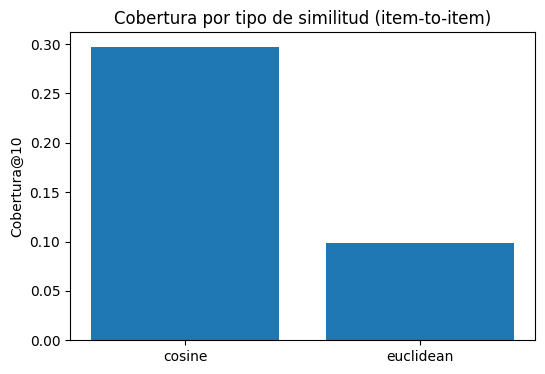

In [21]:
plt.figure(figsize=(6,4))
plt.bar(df_metrics["metric"], df_metrics["coverage@10"])
plt.ylabel("Cobertura@10")
plt.title("Cobertura por tipo de similitud (item-to-item)")
plt.show()

## 7. Cobertura del sistema (análisis adicional)

En esta sección se analiza con más detalle la cobertura del modelo basado en
similitud coseno, variando el valor de K en el Top-K de recomendaciones.

El objetivo es observar el compromiso entre:
- tamaño de la lista recomendada,
- y porcentaje de productos que llegan a ser recomendados al menos una vez.

In [22]:
ks = [5, 10, 20]
coverage_results = []

for k_val in ks:
    cov_k_val, n_rec_items_k, n_total_items_k = coverage_at_k(R_train, S_item_cosine, k=k_val, sample_users=2000)
    coverage_results.append({
        "K": k_val,
        "coverage@K": cov_k_val,
        "items_recomendados": n_rec_items_k,
        "items_totales": n_total_items_k
    })

df_coverage_k = pd.DataFrame(coverage_results)
df_coverage_k

,K,coverage@K,items_recomendados,items_totales
0,5,0.227708,3113,13671
1,10,0.297052,4061,13671
2,20,0.346354,4735,13671


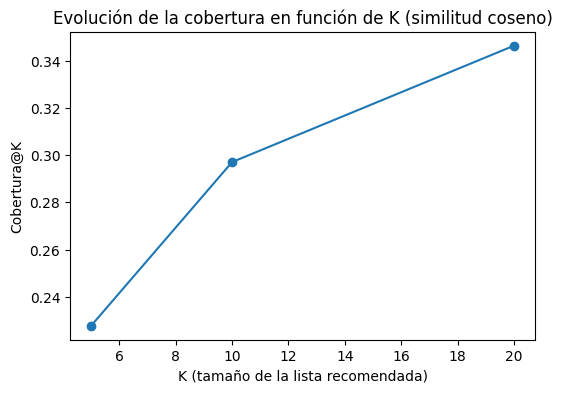

In [23]:
plt.figure(figsize=(6,4))
plt.plot(df_coverage_k["K"], df_coverage_k["coverage@K"], marker="o")
plt.xlabel("K (tamaño de la lista recomendada)")
plt.ylabel("Cobertura@K")
plt.title("Evolución de la cobertura en función de K (similitud coseno)")
plt.show()

## 8. Experimento con subconjunto del 20 % de productos

Con el fin de analizar la robustez del sistema y el impacto de reducir el
volumen de datos, se construye un segundo modelo item-to-item utilizando
solo un subconjunto aleatorio del 20 % de los productos (`parent_asin`).

In [24]:
# Seleccionamos aleatoriamente el 20 % de los productos
rng = np.random.default_rng(42)
unique_items = filtered["parent_asin"].unique()
subset_items = rng.choice(unique_items, size=int(0.2 * len(unique_items)), replace=False)

df_subset = filtered[filtered["parent_asin"].isin(subset_items)].copy()

print("Subset - usuarios:", df_subset["user_id"].nunique())
print("Subset - items:", df_subset["parent_asin"].nunique())
print("Subset - interacciones:", len(df_subset))

Subset - usuarios: 4132
Subset - items: 2734
Subset - interacciones: 6558


### 8.2 Construcción de la matriz usuario–item del subset

Se rehacen los índices numéricos de usuario e ítem para el subconjunto y
se construye la matriz dispersa correspondiente.

In [25]:
# Mapas específicos del subset
user_to_idx_sub = {u: i for i, u in enumerate(df_subset["user_id"].unique())}
item_to_idx_sub = {i: j for j, i in enumerate(df_subset["parent_asin"].unique())}
idx_to_item_sub = {j: i for i, j in item_to_idx_sub.items()}

df_subset["user_idx"] = df_subset["user_id"].map(user_to_idx_sub)
df_subset["item_idx"] = df_subset["parent_asin"].map(item_to_idx_sub)

n_users_sub = len(user_to_idx_sub)
n_items_sub = len(item_to_idx_sub)

R_sub = csr_matrix(
    (df_subset["rating"], (df_subset["user_idx"], df_subset["item_idx"])),
    shape=(n_users_sub, n_items_sub)
)

print("Matriz subset:", R_sub.shape)

# Partición temporal leave-one-out en el subset
df_subset = df_subset.sort_values(by=["user_idx", "timestamp"])
test_indices_sub = df_subset.groupby("user_idx").tail(1).index
df_test_sub = df_subset.loc[test_indices_sub]
df_train_sub = df_subset.drop(test_indices_sub)

print("Interacciones train (subset):", len(df_train_sub))
print("Interacciones test (subset):", len(df_test_sub))

R_train_sub = csr_matrix(
    (df_train_sub["rating"], (df_train_sub["user_idx"], df_train_sub["item_idx"])),
    shape=(n_users_sub, n_items_sub)
)

Matriz subset: (4132, 2734)
Interacciones train (subset): 2426
Interacciones test (subset): 4132


### 8.3 Entrenamiento del modelo item-to-item en el subset

Se vuelve a calcular la matriz de similitud item–item utilizando la métrica de coseno,
y se evalúa el modelo con las mismas métricas que en el caso completo.

In [26]:
# Matriz item–item en el subset (coseno)
S_item_sub = compute_item_similarity(R_train_sub, metric="cosine")

# Evaluación en el subset
k = 10
t0 = time.perf_counter()
prec_k_sub, rec_k_sub = precision_recall_at_k(R_train_sub, df_test_sub, S_item_sub, k=k)
t1 = time.perf_counter()

cov_k_sub, n_rec_items_sub, n_total_items_sub = coverage_at_k(R_train_sub, S_item_sub, k=k, sample_users=2000)

print("=== Modelo subset 20% (cosine) ===")
print(f"Precision@{k}: {prec_k_sub:.4f}")
print(f"Recall@{k}: {rec_k_sub:.4f}")
print(f"Cobertura@{k}: {cov_k_sub:.4f} ({cov_k_sub*100:.2f}%)")
print(f"Items recomendados: {n_rec_items_sub} / {n_total_items_sub}")
print(f"Tiempo de evaluación: {t1 - t0:.2f} segundos")

Matriz de similitud 'cosine' calculada en 0.01 segundos
=== Modelo subset 20% (cosine) ===
Precision@10: 0.0032
Recall@10: 0.0109
Cobertura@10: 0.1503 (15.03%)
Items recomendados: 411 / 2734
Tiempo de evaluación: 2.93 segundos


### 8.4 Comparación full vs subset (20 %)

A continuación se comparan las métricas del modelo entrenado con el conjunto
completo frente al modelo entrenado con solo el 20 % de los productos.

In [30]:
# Fila correspondiente a la métrica coseno en el modelo completo
row_cosine = df_metrics.loc[df_metrics["metric"] == "cosine"].iloc[0]

comparacion = pd.DataFrame([
    {
        "modelo": "Full dataset (cosine)",
        "precision@10": row_cosine["precision@10"],
        "recall@10": row_cosine["recall@10"],
        "coverage@10": row_cosine["coverage@10"],
        "items_recomendados": row_cosine["items_recomendados"],
        "items_totales": row_cosine["items_totales"]
    },
    {
        "modelo": "Subset 20% (cosine)",
        "precision@10": prec_k_sub,
        "recall@10": rec_k_sub,
        "coverage@10": cov_k_sub,
        "items_recomendados": n_rec_items_sub,
        "items_totales": n_total_items_sub
    }
])

comparacion

,modelo,precision@10,recall@10,coverage@10,items_recomendados,items_totales
0,Full dataset (cosine),0.001581,0.014752,0.297052,4061,13671
1,Subset 20% (cosine),0.003212,0.010891,0.150329,411,2734


<h1>Resumen técnico</h1>

<p>
En este trabajo se desarrolla un sistema de recomendación basado en
<b>filtrado colaborativo item-to-item</b>, utilizando como fuente de datos
el conjunto <b>Amazon Reviews 2023 – All_Beauty</b>, que contiene reseñas
de productos de belleza de la plataforma Amazon.
</p>

<p>
El objetivo principal es <b>evaluar el rendimiento</b> de un recomendador
item-to-item sobre datos reales y dispersos, comparando distintas
<b>métricas de similitud entre ítems</b> y analizando cómo cambia el
comportamiento del modelo cuando se reduce el tamaño del catálogo de productos.
</p>

<hr/>

<h2>Datos y preprocesamiento</h2>

<p>
A partir del fichero de reseñas se seleccionan solo las columnas necesarias
para el filtrado colaborativo:
</p>

<ul>
  <li><code>user_id</code>: identificador del usuario</li>
  <li><code>parent_asin</code>: identificador del producto (nivel padre)</li>
  <li><code>rating</code>: valoración numérica</li>
  <li><code>timestamp</code>: momento en que el usuario publicó la reseña</li>
</ul>

<p>Se realiza una limpieza básica (tipos de datos, eliminación de registros incompletos) y un
<b>análisis exploratorio de datos (EDA)</b>:</p>

<ul>
  <li>Número de usuarios, productos e interacciones.</li>
  <li>Distribución de ratings (sesgada hacia valores altos).</li>
  <li>Distribución del número de reseñas por usuario y por producto (típica “larga cola”).</li>
  <li>Evolución temporal del número de reseñas.</li>
</ul>

<p>
Los resultados confirman que se trata de un <b>dataset muy disperso</b>:
la gran mayoría de usuarios y productos tienen pocas interacciones y la
densidad de la matriz usuario–producto es muy baja.
</p>

<p>
Para mejorar la estabilidad del modelo se aplica un
<b>filtrado de actividad mínima</b>:
</p>

<ul>
  <li>Se eliminan usuarios con menos de 3 reseñas.</li>
  <li>Se eliminan productos con menos de 3 reseñas.</li>
</ul>

<p>Tras este filtrado se obtiene un subconjunto de datos con aproximadamente:</p>

<ul>
  <li>~9 000 usuarios</li>
  <li>~13 600 productos</li>
  <li>~33 000 interacciones</li>
</ul>

<hr/>

<h2>Matriz usuario–item</h2>

<p>
A continuación, se construye una <b>matriz usuario–item dispersa</b>
\( R \in \mathbb{R}^{n_{\text{usuarios}} \times n_{\text{items}}} \):
</p>

<ul>
  <li>Cada fila representa un usuario.</li>
  <li>Cada columna representa un producto (<code>parent_asin</code>).</li>
  <li>
    La celda \( R_{u,i} \) contiene el rating que el usuario \( u \) ha dado
    al producto \( i \), o 0 si no existe interacción.
  </li>
</ul>

<p>
La matriz se almacena en formato <b>CSR (Compressed Sparse Row)</b> para reducir
el consumo de memoria y acelerar los cálculos posteriores.
</p>

<hr/>

<h2>Modelo de similitud item-to-item</h2>

<p>
El recomendador se basa en la similitud entre los vectores columna de la
matriz \( R \) (es decir, entre productos). Se implementan dos métricas de similitud:
</p>

<h3>Similitud coseno</h3>

<p>
La similitud coseno entre dos ítems \( i \) y \( j \) se define como:
</p>

<p>
$$
\text{sim}_{\text{cos}}(i,j) =
\frac{\mathbf{r}_i \cdot \mathbf{r}_j}
{\|\mathbf{r}_i\| \, \|\mathbf{r}_j\|}
$$
</p>

<p>
donde \( \mathbf{r}_i \) y \( \mathbf{r}_j \) son las columnas de la matriz de ratings
asociadas a cada producto. Esta métrica es muy habitual en sistemas de recomendación
porque es robusta a la escala de los ratings y funciona bien con datos dispersos.
</p>

<h3>Similitud basada en distancia euclidiana</h3>

<p>También se experimenta con una medida basada en la
<b>distancia euclidiana</b> entre ítems:</p>

<ol>
  <li>
    Primero se calcula la distancia:
    <p>
    $$
    d(i,j) = \|\mathbf{r}_i - \mathbf{r}_j\|_2
    $$
    </p>
  </li>
  <li>
    Después se normaliza para convertirla en similitud en el rango \([0,1]\):
    <p>
    $$
    \text{sim}_{\text{euc}}(i,j) = 1 - \frac{d(i,j)}{\max(d)}
    $$
    </p>
    donde \( \max(d) \) es la mayor distancia observada entre ítems.
  </li>
</ol>

<hr/>

<h2>Generación de recomendaciones</h2>

<p>
Dado un usuario \( u \), el sistema genera recomendaciones
<b>item-to-item</b> siguiendo estos pasos:
</p>

<ol>
  <li>Se identifican los productos que el usuario ya ha valorado y sus ratings.</li>
  <li>Para cada uno de esos productos se buscan los ítems más similares según la matriz de similitud.</li>
  <li>Se agregan las similitudes, ponderadas por el rating del usuario, obteniendo un <b>score</b> para cada ítem candidato.</li>
  <li>Se eliminan de la lista final los productos que el usuario ya ha visto.</li>
  <li>Se ordenan los ítems candidatos por score y se devuelve un <b>Top-K de productos recomendados</b>.</li>
</ol>

<hr/>

<h2>Esquema de evaluación</h2>

<p>
Para evaluar el modelo se utiliza un esquema
<b>leave-one-out temporal</b>:
</p>

<ul>
  <li>Para cada usuario se ordenan sus interacciones por fecha.</li>
  <li>La <b>última interacción</b> se reserva como <b>ejemplo de test</b> (ítem relevante).</li>
  <li>El resto de interacciones se usan para <b>entrenar</b> el modelo.</li>
</ul>

<p>Con esta partición se calculan las métricas estándar:</p>

<ul>
  <li><b>Precision@K</b>: proporción de ítems relevantes dentro de la lista Top-K.</li>
  <li><b>Recall@K</b>: proporción de ítems relevantes recuperados en el Top-K (en este caso, máximo 1 por usuario).</li>
  <li><b>Cobertura@K</b>: porcentaje de productos del catálogo que aparecen al menos una vez en las recomendaciones.</li>
  <li><b>Tiempo de evaluación</b>: tiempo necesario para generar y evaluar recomendaciones en el conjunto de test.</li>
</ul>

<hr/>

<h2>Resultados principales</h2>

<p>
Los resultados muestran que la <b>similitud coseno</b> ofrece un mejor rendimiento
que la basada en distancia euclidiana:
</p>

<ul>
  <li>Mayor <b>Precision@10</b> y <b>Recall@10</b>.</li>
  <li>
    Mucho mayor <b>Cobertura@10</b>
    (alrededor del 30 % de los productos aparecen alguna vez recomendados
    frente a ~10 % con euclidiana).
  </li>
  <li>Un tiempo de cálculo razonable para un dataset de este tamaño.</li>
</ul>

<p>
Aunque las cifras absolutas de precisión y recall son bajas (algo habitual en datos tan dispersos),
el modelo es <b>coherente</b> y refleja patrones reales de comportamiento de usuarios.
</p>

<hr/>

<h2>Experimento con un subconjunto del 20 % de productos</h2>

<p>
Para estudiar la <b>robustez del sistema</b> frente a reducciones de datos,
se repite todo el proceso anterior utilizando solo un
<b>subconjunto aleatorio del 20 % de los productos</b>:
</p>

<ul>
  <li>Se selecciona aleatoriamente el 20 % de los <code>parent_asin</code>.</li>
  <li>Se conservan únicamente las reseñas asociadas a esos productos.</li>
  <li>Se vuelve a construir la matriz usuario–item, la similitud coseno y el modelo de recomendación.</li>
  <li>Se evalúa de nuevo con Precision@10, Recall@10 y Cobertura@10.</li>
</ul>

<p>
Los resultados muestran que:
</p>

<ul>
  <li>
    La <b>precisión y el recall disminuyen</b>, porque el modelo dispone de menos información
    sobre las preferencias de los usuarios.
  </li>
  <li>
    La <b>cobertura</b> también se reduce, ya que el catálogo es más pequeño y hay menos
    productos distintos que puedan aparecer en las recomendaciones.
  </li>
</ul>

<p>
Sin embargo, el sistema <b>sigue funcionando</b>: sigue siendo capaz de generar recomendaciones
razonables, aunque de menor calidad y diversidad. Esto confirma que el filtrado colaborativo
item-to-item <b>necesita un volumen suficiente de productos e interacciones</b> para rendir al máximo,
pero también que puede seguir siendo útil incluso cuando se trabaja con un subconjunto reducido
del catálogo.
</p>

<hr/>
